#  Rating Prediction

In [44]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from scipy.sparse import hstack
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset

df = pd.read_csv("Review_Rating_Datafile.csv")
df.head(10)

,Unnamed: 0,Review_title,Review_text,Ratings
0,0,Suitable for School kids,\n If you are a College student or a professi...,2.0 out of 5 stars
1,1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2.0 out of 5 stars
2,2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2.0 out of 5 stars
3,3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2.0 out of 5 stars
4,4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2.0 out of 5 stars
5,5,Battery life,\n Battery backup give only one hour . What d...,2.0 out of 5 stars
6,6,No for professional works,\n Blue screen while power on the linux Opera...,2.0 out of 5 stars
7,7,monitor power issue,\n monitor is not turning on from 2 weeks of ...,2.0 out of 5 stars
8,8,waste,\n waste of money sometimes screen was marks\n,2.0 out of 5 stars
9,9,Not able to download warranty card,\n Good\n,2.0 out of 5 stars


In [3]:
# Drop unnecessary column
df.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
# Rows and Columns
df.shape

(20000, 3)

In [5]:
# Checking the null values in the dataset
df.isnull().sum()

Review_title    3574
Review_text     3277
Ratings         3573
dtype: int64

In [6]:
# Drop the null values
df.dropna(inplace=True)

<AxesSubplot:>

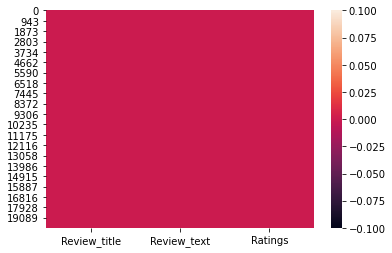

In [7]:
# Visualization for null values
sns.heatmap(df.isnull())

In [8]:

df.shape

(16345, 3)

In [9]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16345 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  16345 non-null  object
 1   Review_text   16345 non-null  object
 2   Ratings       16345 non-null  object
dtypes: object(3)
memory usage: 510.8+ KB


In [10]:
# checking the columns name
df.columns

Index(['Review_title', 'Review_text', 'Ratings'], dtype='object')

In [11]:
# checking the unique values 
df['Ratings'].unique()

array(['2.0 out of 5 stars', '3.0 out of 5 stars', '1.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars'], dtype=object)

In [12]:

df['Ratings'] = df['Ratings'].replace('1.0 out of 5 stars',1)
df['Ratings'] = df['Ratings'].replace('2.0 out of 5 stars',2)
df['Ratings'] = df['Ratings'].replace('3.0 out of 5 stars',3)
df['Ratings'] = df['Ratings'].replace('4.0 out of 5 stars',4)
df['Ratings'] = df['Ratings'].replace('5.0 out of 5 stars',5)
df['Ratings'] = df['Ratings'].astype('int')
df['Ratings'].unique()

array([2, 3, 1, 5, 4])

In [13]:
#"Review_title" and "Review_text" columns into one single column 
df['Review'] = df['Review_title'].map(str)+' '+df['Review_text']
df

,Review_title,Review_text,Ratings,Review
0,Suitable for School kids,\n If you are a College student or a professi...,2,Suitable for School kids \n If you are a Coll...
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2,Misrepresentation on MS Office 2019 license - ...
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2,The sold me renewed laptop \n It’s look like ...
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2,Amazon dupes with specification/ battery sucks...
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2,Display back light issue \n Display gone with...
...,...,...,...,...
19995,Z thunder is now connected 😂😂😂,\n Too good ... I'm satisfied with this produ...,5,Z thunder is now connected 😂😂😂 \n Too good .....
19996,Nice headphone,\n Overall a very good headphone in this pric...,5,Nice headphone \n Overall a very good headpho...
19997,My Experience,"\n This product is the best at this price, If...",5,My Experience \n This product is the best at ...
19998,Product that's worth the money.,\n It's a decent brand. Till now it's working...,5,Product that's worth the money. \n It's a dec...


In [14]:
df['Review'][0]

'Suitable for School kids \n  If you are a College student or a professional who depends heavily on laptop for pretty much everyday then  this laptop is not for you. It hangs more often than it runs. Cannot install essential computer science software such as Eclipse or android studio because then this laptop just dies.<br><br>I took this laptop thinking that it will have good performance based on its configuration.<br><br>But if you are someone who wants to attend online classes or just browse, then you may go for this laptop.\n'

In [15]:
df['Review'][1]

'Misrepresentation on MS Office 2019 license - it is one month trial \n  Update after one month usage - MS Office 2019 preinstalled edition became unlicensed version within 30 days and refused to activate. HP support shared their product sheet that stated that this laptop came only with a trial version of MS Office 2019. Now I am chasing seller Appario Retail to honour the commitment.<br><br>Bad experience after paying high price (around ₹67,000) for preinstalled genuine software.<br><br>Other wise product has sleek looks, superfast fingerprint scanner, very good display, very responsive touchpad, decent (but tinny) speakers, USB C and barrel plug charging options and under 10 second boot up (SSD drive). Preloaded with Win10 Home and MS Office (not sure whether trial or full version). Drawbacks - weighs 1.42 kg, base gets warm rather quickly and so does the power adapter. Decent for a college student.\n'

In [16]:
df['Review'][2]

'The sold me renewed laptop \n  It’s look like renewed laptop because laptop charging jack is loose and left side speaker sounds like it’s tear. Bad sound quality  and finger sensor quality look like 2011 touch phone of wing and any Chinese phone touch. Waste of money and one more thing day by day Amazon product quality getting poor\n'

In [17]:
# change in full meaning words

def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

# Lowercasing the alphabets
df['Review'] = df['Review'].apply(lambda x : x.lower())
df['Review'] = df['Review'].apply(lambda x : decontracted(x))

# Removing punctuations from the review
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n',' ')

In [18]:
# Removing all the stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [19]:
df['Review'][0]

'suitable school kids college student professional depends heavily laptop pretty much everyday laptop hangs often runs cannot install essential computer science software eclipse android studio laptop dies took laptop thinking good performance based configuration someone wants attend online classes browse may go laptop'

In [20]:
df['Review'][1]

'misrepresentation ms office 2019 license one month trial update one month usage ms office 2019 preinstalled edition became unlicensed version within 30 days refused activate hp support shared product sheet stated laptop came trial version ms office 2019 chasing seller appario retail honour commitment bad experience paying high price around 67000 preinstalled genuine software wise product sleek looks superfast fingerprint scanner good display responsive touchpad decent tinny speakers usb c barrel plug charging options 10 second boot ssd drive preloaded win10 home ms office sure whether trial full version drawbacks weighs 142 kg base gets warm rather quickly power adapter decent college student'

In [21]:
df['Review'][2]

'sold renewed laptop look like renewed laptop laptop charging jack loose left side speaker sounds like tear bad sound quality finger sensor quality look like 2011 touch phone wing chinese phone touch waste money one thing day day amazon product quality getting poor'

In [22]:
# Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Defining function to lemmatize our text
def lemmatize_sentence(sentence):
    # tokenize the sentence and find the pos_tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)    

df['Review'] = df['Review'].apply(lambda x : lemmatize_sentence(x))

In [23]:
df['Review'][0]

'suitable school kid college student professional depend heavily laptop pretty much everyday laptop hang often run can not install essential computer science software eclipse android studio laptop dy take laptop thinking good performance base configuration someone want attend online class browse may go laptop'

In [24]:
df['Review'][1]

'misrepresentation m office 2019 license one month trial update one month usage m office 2019 preinstalled edition become unlicensed version within 30 day refuse activate hp support share product sheet state laptop come trial version m office 2019 chase seller appario retail honour commitment bad experience pay high price around 67000 preinstalled genuine software wise product sleek look superfast fingerprint scanner good display responsive touchpad decent tinny speaker usb c barrel plug charge option 10 second boot ssd drive preloaded win10 home m office sure whether trial full version drawback weigh 142 kg base get warm rather quickly power adapter decent college student'

In [25]:
df['Review'][2]

'sell renew laptop look like renew laptop laptop charge jack loose leave side speaker sound like tear bad sound quality finger sensor quality look like 2011 touch phone wing chinese phone touch waste money one thing day day amazon product quality get poor'

In [26]:
# Noise removal function
def scrub_words(text):
    # remove HTML markup
    text = re.sub("(<.*?>)", "", text)
    # remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    # remove white space
    text = text.strip()
    return text

df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

In [27]:
df['Review'][0]

'suitable school kid college student professional depend heavily laptop pretty much everyday laptop hang often run can not install essential computer science software eclipse android studio laptop dy take laptop thinking good performance base configuration someone want attend online class browse may go laptop'

In [28]:
df['Review'][1]

'misrepresentation m office  license one month trial update one month usage m office  preinstalled edition become unlicensed version within  day refuse activate hp support share product sheet state laptop come trial version m office  chase seller appario retail honour commitment bad experience pay high price around  preinstalled genuine software wise product sleek look superfast fingerprint scanner good display responsive touchpad decent tinny speaker usb c barrel plug charge option  second boot ssd drive preloaded win home m office sure whether trial full version drawback weigh  kg base get warm rather quickly power adapter decent college student'

In [29]:
df['Review'][2]

'sell renew laptop look like renew laptop laptop charge jack loose leave side speaker sound like tear bad sound quality finger sensor quality look like  touch phone wing chinese phone touch waste money one thing day day amazon product quality get poor'

In [30]:
# Creating column for word counts in the review text
df['Review_WC'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WC', 'Review']].head(10)

,Review_WC,Review
0,44,suitable school kid college student profession...
1,103,misrepresentation m office license one month ...
2,43,sell renew laptop look like renew laptop lapto...
3,21,amazon dupe specification battery suck nbspi s...
4,16,display back light issue display go month any...
5,7,battery life battery backup give one hour
6,18,professional work blue screen power linux oper...
7,8,monitor power issue monitor turn week purchase
8,6,waste waste money sometimes screen mark
9,5,able download warranty card good


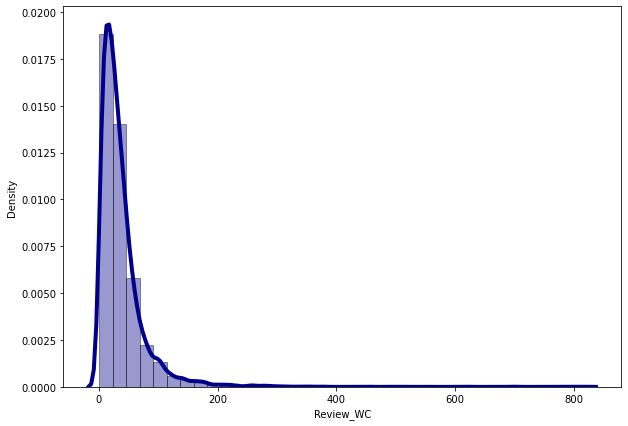

In [31]:
# Density plot and histogram of all word count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [32]:
# Creating column for character counts in the review text
df['Review_CC'] = df['Review'].str.len()
df[['Review_CC','Review']].head(10)

,Review_CC,Review
0,309,suitable school kid college student profession...
1,654,misrepresentation m office license one month ...
2,250,sell renew laptop look like renew laptop lapto...
3,126,amazon dupe specification battery suck nbspi s...
4,102,display back light issue display go month any...
5,41,battery life battery backup give one hour
6,125,professional work blue screen power linux oper...
7,47,monitor power issue monitor turn week purchase
8,39,waste waste money sometimes screen mark
9,32,able download warranty card good


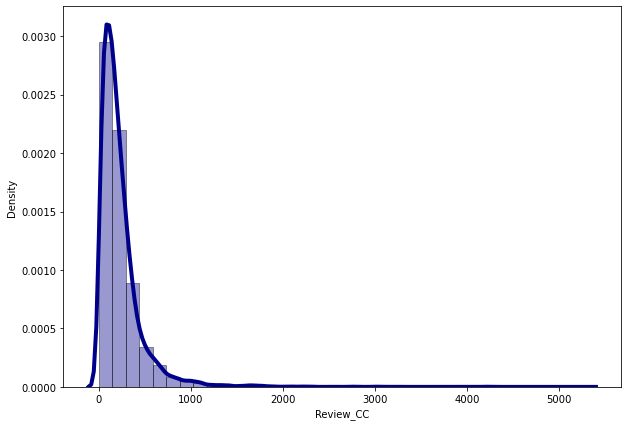

In [33]:
# Density plot and histogram of all character count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()


In [34]:
# Applying zscore to remove outliers
z_score = zscore(df[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]

In [35]:
df.shape

(16058, 6)

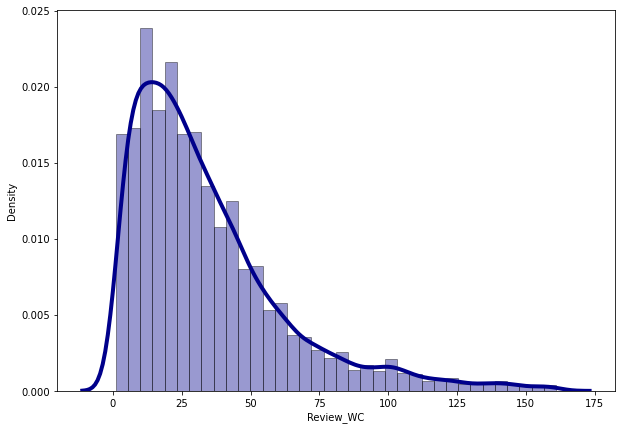

In [36]:
# Density plot and histogram of all word count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()


5    3716
1    3514
4    3152
3    2923
2    2753
Name: Ratings, dtype: int64


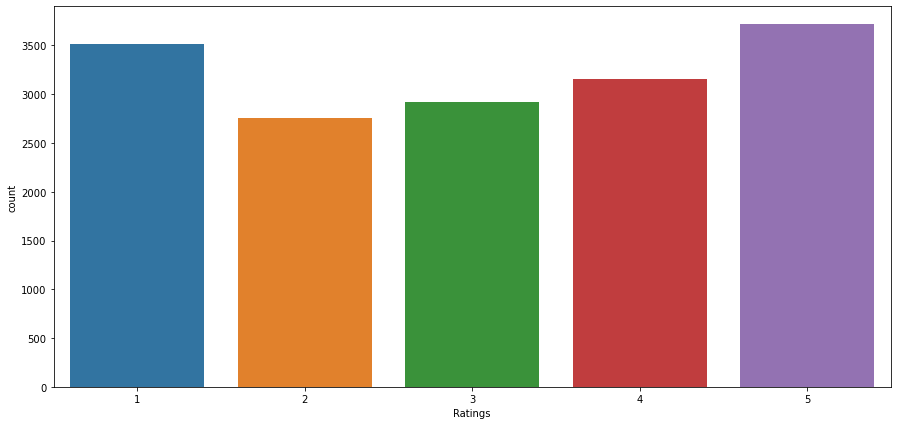

In [37]:
# Checking the count of target column values
plt.figure(figsize=(15,7))
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

In [38]:
# Separating features and labels here
x = df['Review']
y = df['Ratings']

In [39]:
# Using the n_gram tfidf vectorizer (Word vectors)
word_vectorizer = TfidfVectorizer(sublinear_tf = True,
                                  strip_accents = 'unicode',
                                  analyzer = 'word',
                                  token_pattern = r'\w{1,}',
                                  stop_words = 'english',
                                  ngram_range = (1,3),
                                  max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

# Character vectors
char_vectorizer = TfidfVectorizer(sublinear_tf = True,
                                  strip_accents = 'unicode',
                                  analyzer = 'char',
                                  stop_words = 'english',
                                  ngram_range = (2,6),
                                  max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

# I will now combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features, train_word_features])

In [40]:
state = 42
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.30, random_state = state)

# Lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (11240, 150000)
x_test (4818, 150000)
y_train (11240,)
y_test (4818,)


In [41]:
# Defining the Classification Machine Learning Algorithms
rf = RandomForestClassifier()
lr = LogisticRegression()
mnb = MultinomialNB()
sgd = SGDClassifier()
# Creating a function to train and test the model with evaluation metrics
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)*100
    print(f"ACCURACY SCORE PERCENTAGE:", accuracy)
    # Confusion matrix and Classification report
    print(f"CLASSIFICATION REPORT: \n {classification_report(y_test, pred)}")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_test, pred)}\n")
    print("-"*120)
    print("\n")

In [42]:
for model in [lr,mnb,sgd,rf]:
    BuiltModel(model)

******************************LogisticRegression******************************
ACCURACY SCORE PERCENTAGE: 67.3931091739311
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           1       0.73      0.83      0.77      1091
           2       0.62      0.51      0.56       812
           3       0.60      0.53      0.56       857
           4       0.62      0.59      0.60       943
           5       0.73      0.83      0.78      1115

    accuracy                           0.67      4818
   macro avg       0.66      0.66      0.66      4818
weighted avg       0.67      0.67      0.67      4818

CONFUSION MATRIX: 
 [[904  93  58  18  18]
 [194 412 125  50  31]
 [ 87 116 454 130  70]
 [ 37  32  97 554 223]
 [ 21  10  22 139 923]]

------------------------------------------------------------------------------------------------------------------------


******************************MultinomialNB******************************
ACCURACY SCORE PERCENTAGE: 55

# cross_validation

In [45]:

def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score:", scores)
    print("\n")
    
for model in [lr,mnb,sgd,rf]:
    cross_val(model)    

******************************LogisticRegression******************************
Cross validation score: 60.891122850333936


******************************MultinomialNB******************************
Cross validation score: 51.5939669311715


******************************SGDClassifier******************************
Cross validation score: 60.21222563918123


******************************RandomForestClassifier******************************
Cross validation score: 61.25226079169385




## 